In [1]:
import pprint

import numpy as np
import lightgbm as lgb

from otb.tasks import TaskApi
from otb.plot import plot_predictions

In [2]:
%matplotlib inline

In [3]:
pprinter = pprint.PrettyPrinter(indent=4, width=120, compact=True)

### load the tasks

In [4]:
task_api = TaskApi()

In [6]:
task = task_api.get_task("regression.mlo_cn2.dropna.Cn2_15m")

The `task` object gives access to the description and associated metadata surrounding the task.

In [7]:
task_info = task.get_info()
pprinter.pprint(task_info)

{   'description': 'Regression task for MLO Cn2 data, where the last 12 days are set aside for evaluation',
    'description_long': 'This dataset evaluates regression approaches for predicting the extent of optical turbulence, '
                        'as measured by Cn2 at an elevation of 15m. Optical turbulence on data collected at the Mauna '
                        'Loa Solar Observatory between 27 July 2006 and 8 August 2006, inclusive, are used to evaluate '
                        'prediction accuracy under the root-mean square error metric.',
    'dropna': True,
    'ds_name': 'mlo_cn2',
    'eval_metrics': ['root_mean_square_error', 'r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'],
    'log_transform': True,
    'obs_lat': 19.53,
    'obs_lon': -155.57,
    'obs_tz': 'US/Hawaii',
    'remove': ['base_time', 'Cn2_6m', 'Cn2_15m', 'Cn2_25m'],
    'target': 'Cn2_15m',
    'test_idx': ['10367:13943'],
    'train_idx': ['0:8367'],
    'val_idx': ['8367:10367']}


As seen above, the `regression.mlo_cn2.dropna.Cn2_15m` task is focused on predicting the optical turbulence strength at a height of 15 \[m\] at the Mauna Loa Observatory (MLO) in Hawaii. The task uses the `mlo_cn2` dataset, which is a dataset of optical turbulence strength measurements at the MLO. The `task` contains an `obs_tz` attribute which specifies the timezone of the observatory. The latitude and longitude of the observatory are also provided as `obs_lat` and `obs_lon` attributes.

The `task` also contains a `target` attribute which specifies the target feature for the task. The task is focused on predicting the optical turbulence strength at a height of 15 \[m\], and the optical turbulence strength measurements at heights of 6 and 25 \[m\] are assumed to be unavailable for training or inference.

To ensure consistency and robust comparison between modeling approaches, the `train_idx`, `test_idx`, and `val_idx` are fixed for the given task. The `train_idx` and `val_idx` attributes specify the indices of the dataset which are available for model development. The `test_idx` attribute specifies the indices of the dataset which are used to evaluate the model during and compare against existing benchmarks for the task.

The task is evaluated using the root mean squared error (RMSE), explained variance score (EVS), mean absolute error (MAE), and mean absolute percentage error (MAPE) metrics. The task is evaluated on the test and validation splits of the dataset, and the training split is used for training new models.

Get the training data

In [8]:
X_train, y_train = task.get_train_data(data_type="pd")

Define your model

In [9]:
model = lgb.LGBMRegressor()

Once we have defined the model, we can use the training data provided by the task API (`X_train` and `y_train`).


In [10]:
model.fit(X_train, y_train)

LGBMRegressor()

We can tune hyper parameters using the validation data provided by the task API (`X_val` and `y_val`). In this case, we move directly to evaluation on the test set for our regression task.

Evaluate your model

In [11]:
task.evaluate_model(predict_call=model.predict)

{'root_mean_square_error': {'metric_value': 0.21550584034473647,
  'valid_predictions': 2449},
 'r2_score': {'metric_value': 0.8936031659084048, 'valid_predictions': 2449},
 'mean_absolute_error': {'metric_value': 0.15718607854371786,
  'valid_predictions': 2449},
 'mean_absolute_percentage_error': {'metric_value': 0.011320035736497307,
  'valid_predictions': 2449}}

The `otb` package includes benchmarks for the models defined in the `otb.benchmark.models` module. Each task can access the evaluation results for the benchmark models using the `get_benchmark_results` method.

Compare against benchmarks

In [12]:
benchmarks = task.get_benchmark_info()

In [13]:
pprinter.pprint(benchmarks)

{   'lgbm': {   'mean_absolute_error': {'metric_value': 0.15718607854371786, 'valid_predictions': 2449},
                'mean_absolute_percentage_error': {'metric_value': 0.011320035736497307, 'valid_predictions': 2449},
                'r2_score': {'metric_value': 0.8936031659084048, 'valid_predictions': 2449},
                'root_mean_square_error': {'metric_value': 0.21550584034473647, 'valid_predictions': 2449}},
    'macro_meterological': {   'mean_absolute_error': {'metric_value': 0.5874813616291615, 'valid_predictions': 813},
                               'mean_absolute_percentage_error': {   'metric_value': 0.04435200340221298,
                                                                     'valid_predictions': 813},
                               'r2_score': {'metric_value': -1.0279853591950694, 'valid_predictions': 813},
                               'root_mean_square_error': {   'metric_value': 0.7138353117427121,
                                                   

We can easily access the top two existing models using the `top_models` method of the `task`.

In [14]:
top_2_models = task.top_models(n=2, metric="mean_absolute_percentage_error")

In [15]:
pprinter.pprint(top_2_models)

{   'lgbm': {   'mean_absolute_error': {'metric_value': 0.15718607854371786, 'valid_predictions': 2449},
                'mean_absolute_percentage_error': {'metric_value': 0.011320035736497307, 'valid_predictions': 2449},
                'r2_score': {'metric_value': 0.8936031659084048, 'valid_predictions': 2449},
                'root_mean_square_error': {'metric_value': 0.21550584034473647, 'valid_predictions': 2449}},
    'mean_regression': {   'mean_absolute_error': {'metric_value': 0.5297892689704895, 'valid_predictions': 2449},
                           'mean_absolute_percentage_error': {   'metric_value': 0.03830472752451897,
                                                                 'valid_predictions': 2449},
                           'r2_score': {'metric_value': -0.00029260682285126016, 'valid_predictions': 2449},
                           'root_mean_square_error': {'metric_value': 0.6607820391654968, 'valid_predictions': 2449}},
    'possible_predictions': 1892}


Our model performs better than the existing benchmarks, and we can programmatically add it to the `experiments.json` file for future comparison.

In [16]:
_ = task.evaluate_model(
        predict_call=model.predict,
        include_as_benchmark=True,
        model_name="lgbm",
    )

Let's validate that this new model is included in our benchmark results.

In [17]:
top_3_models = task.top_models(n=3, metric="mean_absolute_percentage_error")

In [18]:
pprinter.pprint(top_3_models)

{   'lgbm': {   'mean_absolute_error': {'metric_value': 0.15718607854371786, 'valid_predictions': 2449},
                'mean_absolute_percentage_error': {'metric_value': 0.011320035736497307, 'valid_predictions': 2449},
                'r2_score': {'metric_value': 0.8936031659084048, 'valid_predictions': 2449},
                'root_mean_square_error': {'metric_value': 0.21550584034473647, 'valid_predictions': 2449}},
    'mean_regression': {   'mean_absolute_error': {'metric_value': 0.5297892689704895, 'valid_predictions': 2449},
                           'mean_absolute_percentage_error': {   'metric_value': 0.03830472752451897,
                                                                 'valid_predictions': 2449},
                           'r2_score': {'metric_value': -0.00029260682285126016, 'valid_predictions': 2449},
                           'root_mean_square_error': {'metric_value': 0.6607820391654968, 'valid_predictions': 2449}},
    'offshore_macro_meterological': { 

In addition to computing metrics and comparing with existing benchmarks, the `evaluate_model` method of the `task` can be used to return the model's predictions on the test. This can be used to visualize the model's performance, as well as to investigate trends in prediction error.

In [19]:
_, y_test = task.get_test_data(data_type='pd')
_, y_pred = task.evaluate_model(model.predict, return_predictions=True)

We can inspect these predictions visually using the `plot_predictions` method.

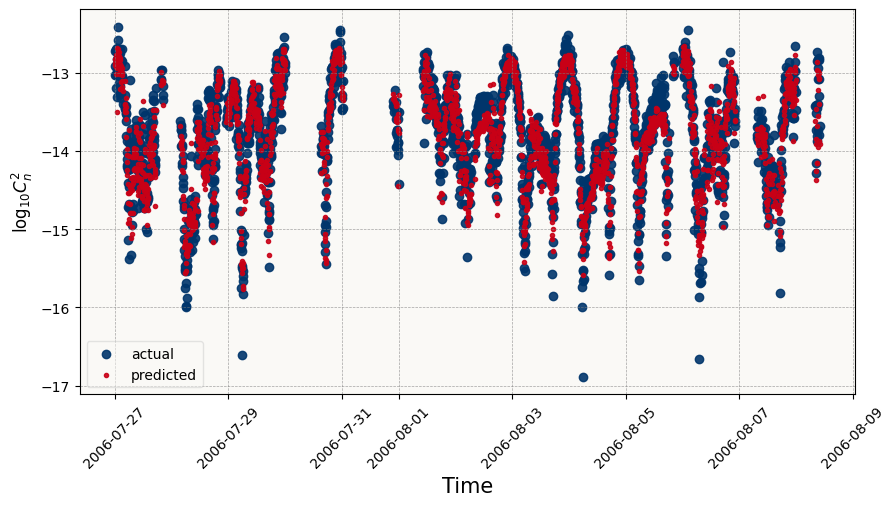

In [20]:
plot_predictions(y_test, y_pred)

Returning to our `MeanRegressionModel`, we can obtain the model's predictions for the test set for this task, and compare them against the ground truth values and the predictions of the LightGBM model.

In [21]:
class MeanRegressionModel:

    def __init__(
        self,
        name: str,
        **kwargs
    ):
        self.name = name
        self.mean = np.nan
    
    def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
        # maintain the same interface as the other models
        self.mean = np.mean(y)

    def predict(self, X: 'pd.DataFrame'):
        # predict the mean for each entry in X
        return np.full(len(X), self.mean)


In [22]:
mean_model = MeanRegressionModel(name="mean")
mean_model.train(X_train, y_train)

In [23]:
_, y_pred_mean_model = task.evaluate_model(mean_model.predict, return_predictions=True)

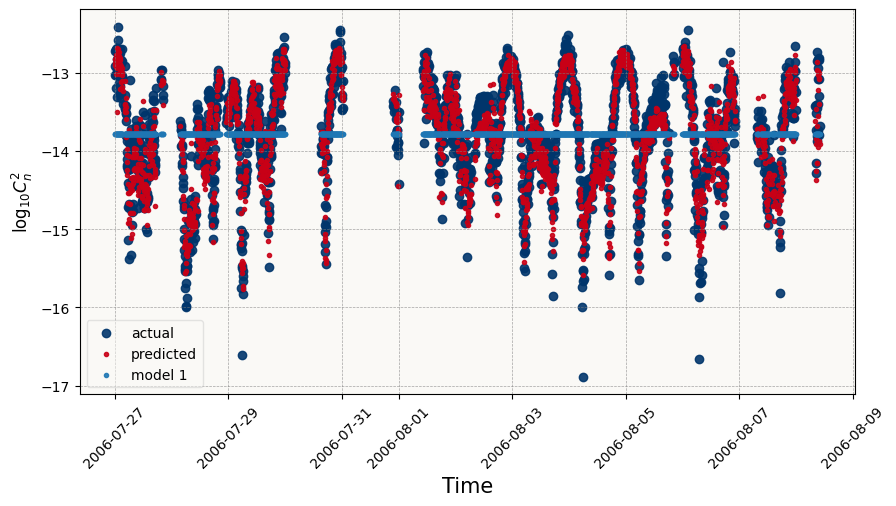

In [24]:
plot_predictions(y_test, y_pred, y_pred_mean_model)

While the evaluation metrics for the task indicate that the `MeanRegressionModel` has higher prediction error than the LightGBM model, the plot illustrates the qualitative difference between the two models. The `MeanRegressionModel` predicts the mean value seen during training, while the LightGBM model is able to capture the trends in the data.